In [107]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [108]:
# define constants
# output parameters
y_names = ['energy_high', 'energy_low']

# input parameters
# x_names = [c for c in df.columns if c not in y_names]
x_names = ['vsup_ratio', 'iload_ratio', 'rgon', 'rgoff', 't_dead']

# seed for replication
seed = 13

In [109]:
# loading data
df_raw = pd.read_csv('./data/GS66516T_big.csv', sep=';')[x_names + y_names]

# filter data for energies higher than 10nJ and smaller than 500uJ
df = df_raw[(df_raw.energy_high < 500e-6) & (df_raw.energy_high > 10e-9) & (df_raw.energy_low < 500e-6) & (df_raw.energy_low > 10e-9)]

In [110]:
# create scaler and scale data, take the log of the data to assume a gaussian curve for one side shifted data -> better learning with gaussian curve because same shape like weight function
x_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(df[x_names].values)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(np.log10(df[y_names].values))

In [111]:
# split data in train and test data and save as df 
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1, random_state=seed)

df_x_test = pd.DataFrame(x_scaler.inverse_transform(x_test), columns=x_names)
df_y_test = pd.DataFrame(10**y_scaler.inverse_transform(y_test), columns=y_names)
df_x_train = pd.DataFrame(x_scaler.inverse_transform(x_train), columns=x_names)
df_y_train = pd.DataFrame(10**y_scaler.inverse_transform(y_train), columns=y_names)

In [112]:
# create net and set hyper parameters
mlp = MLPRegressor(hidden_layer_sizes=(64, 128, 64, 32), max_iter=1000, alpha=0.0001, solver='adam', random_state=seed, batch_size=32, tol=1e-6, n_iter_no_change=100, early_stopping=True)

# train neural net
_ = mlp.fit(x_train, y_train)

In [113]:

# write function to put in real values 
def predict(df:pd.DataFrame):
    x_scaled_pred = x_scaler.transform(df.values)
    y_scaled_pred = mlp.predict(x_scaled_pred)
    y = 10**y_scaler.inverse_transform(y_scaled_pred)
    return pd.DataFrame(y, columns=y_names)

In [114]:
# predict solution
df_y_pred = predict(df_x_test)

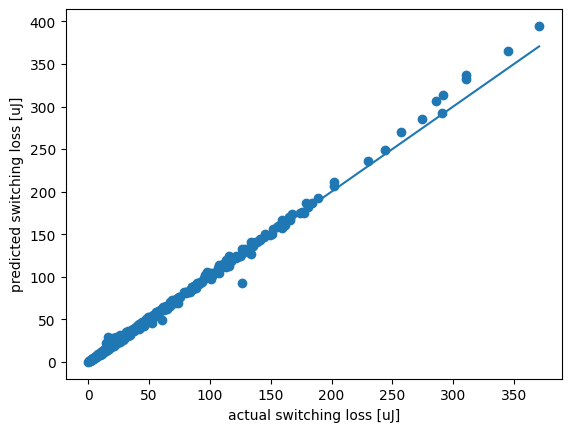

In [125]:

# plot prediction
# plt.scatter(np.log10(y_scaler.inverse_transform(y_test)*1e6), np.log10(y_scaler.inverse_transform(y_pred)*1e6))
plt.scatter(df_y_test[y_names[0]] * 1e6, df_y_pred[y_names[0]] * 1e6)
plt.plot(np.linspace(0, max(df_y_test[y_names[0]]*1e6), 10),np.linspace(0, max(df_y_test[y_names[0]]*1e6), 10))
plt.xlabel('actual switching loss [uJ]')
plt.ylabel('predicted switching loss [uJ]')
plt.show()

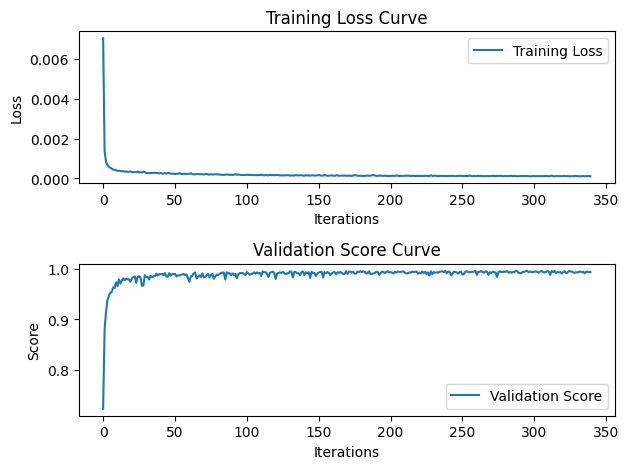

In [116]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plotting the training loss
ax1.plot(range(mlp.n_iter_), mlp.loss_curve_, label='Training Loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Curve')
ax1.legend()

# Plotting the validation score
ax2.plot(range(mlp.n_iter_), mlp.validation_scores_, label='Validation Score')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Score')
ax2.set_title('Validation Score Curve')
ax2.legend()

plt.tight_layout()
fig.show()

In [117]:
# error in percent
df_y = predict(df_x_train)
df_loss = (abs(df_y - df_y_train)/df_y_train)*100
df_loss.sort_values(by='energy_high')

energy_high  energy_low
2358     0.001129    3.460075
1974     0.001399    2.528647
2899     0.003036    1.100753
1666     0.003064    1.066603
4049     0.004546    3.766565
...           ...         ...
1524    58.384590   12.145870
2585    58.768168   40.706408
1479    65.271209   47.603921
3507    68.391737   23.757921
4266    89.281672    9.108777

[4348 rows x 2 columns]

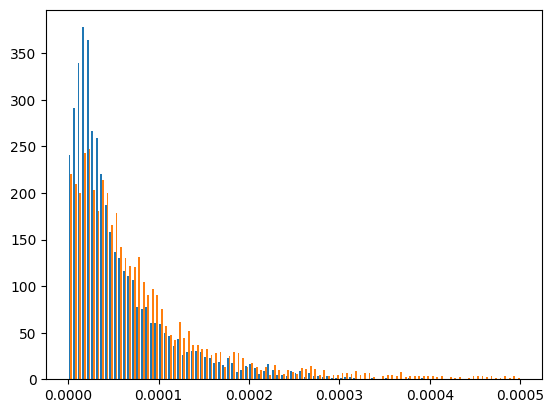

In [118]:
plt.hist(df_y_train, bins=100)
plt.show()

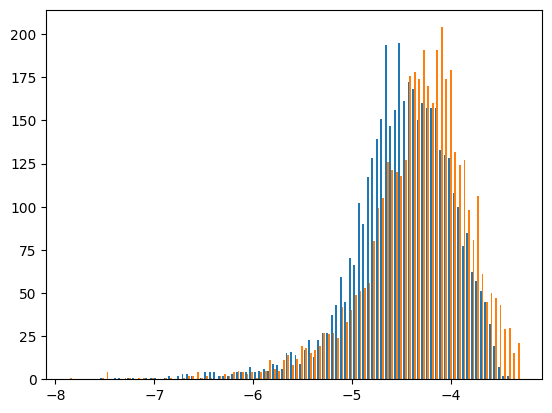

In [121]:
# better partion of the trainig data (more like gaussian curve)
plt.hist(np.log10(df_y_train), bins=100)
plt.show()

In [119]:
df_y_train.sort_values(by='energy_low')

energy_high    energy_low
2241  1.061341e-07  1.349124e-08
2585  4.197094e-08  2.915508e-08
4151  4.808969e-07  3.160932e-08
1929  4.040278e-06  3.173790e-08
3253  6.375833e-07  3.270716e-08
...            ...           ...
3619  3.629826e-05  4.853272e-04
851   8.523596e-05  4.901837e-04
1612  9.089573e-05  4.902170e-04
1698  9.502165e-05  4.947796e-04
2871  4.900012e-05  4.997982e-04

[4348 rows x 2 columns]

In [120]:
df_loss.describe()

energy_high   energy_low
count  4348.000000  4348.000000
mean      3.747136     5.246898
std       5.173980     5.786374
min       0.001129     0.000791
25%       1.062434     1.938393
50%       2.398824     4.188126
75%       4.531354     6.816839
max      89.281672   161.670396